# Federated Averaging under Realistic Imperfections

Implementation of synchronous and asynchronous FedAvg for MNIST classification.

**Course Project:** Optimization for Distributed, Federated, and Asynchronous Systems

This notebook demonstrates:
- Synchronous FedAvg baseline
- Asynchronous FedAvg with arbitrary delays
- IID vs non-IID data partitioning
- Client availability modeling
- Comparative analysis of convergence behavior

## 1. Setup

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset, Dataset
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict, deque
import copy
import random
from typing import List, Dict, Tuple, Optional

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {'cuda' if torch.cuda.is_available() else 'cpu'}")

PyTorch version: 2.9.1
Device: cpu


In [17]:
# Configuration dictionary - all hyperparameters in one place
config = {
    # Federated setup
    'num_clients': 100,
    'client_fraction': 0.1,  # C: fraction of clients selected per round
    'local_epochs': 5,        # E: number of local epochs
    'local_batch_size': 32,   # B: local batch size
    'learning_rate': 0.01,
    'num_rounds': 100,
    
    # Data partitioning
    'data_mode': 'iid',  # 'iid', 'dirichlet', or 'label_shard'
    'dirichlet_alpha': 0.5,  # Lower = more heterogeneous (try 0.1, 0.5, 1.0)
    'labels_per_client': 2,  # For label_shard mode
    
    # Delay and availability
    'delay_mode': 'none',  # 'none', 'uniform', 'exponential'
    'max_delay': 5,  # Maximum delay in rounds
    'p_available': 1.0,  # Client availability probability
    'max_staleness': None,  # None = no bound, otherwise drop updates older than this
    
    # Eval and logging
    'eval_every': 5,  # Evaluate test accuracy every N rounds
    'seed': 42,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu'
}

def set_seed(seed):
    """Set random seeds for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(config['seed'])
print("Configuration loaded and seed set.")

Configuration loaded and seed set.


## 2. Data Loading and Partitioning

We implement three partitioning schemes:

1. **IID**: Random shuffle and equal split - each client gets uniform random samples
2. **Dirichlet**: Sample label proportions from Dir(α) - controls statistical heterogeneity
   - Lower α → more skewed label distributions per client
   - α→∞ approaches IID
3. **Label Shard**: Each client gets examples from only K classes - extreme non-IID

In [18]:
# Download MNIST
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # MNIST mean and std
])

train_dataset = torchvision.datasets.MNIST(
    root='./data', train=True, download=True, transform=transform
)

test_dataset = torchvision.datasets.MNIST(
    root='./data', train=False, download=True, transform=transform
)

test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Training samples: 60000
Test samples: 10000


In [19]:
def partition_iid(dataset, num_clients):
    """
    Partition dataset into equal-sized IID shards.
    
    Returns:
        List of index arrays, one per client
    """
    n_samples = len(dataset)
    indices = np.random.permutation(n_samples)
    shard_size = n_samples // num_clients
    
    client_indices = []
    for i in range(num_clients):
        start = i * shard_size
        end = start + shard_size if i < num_clients - 1 else n_samples
        client_indices.append(indices[start:end])
    
    return client_indices


def partition_dirichlet(dataset, num_clients, alpha=0.5):
    """
    Partition using Dirichlet distribution over labels.
    
    For each client, sample p_k ~ Dir(alpha) giving the proportion of
    each label in that client's dataset. Lower alpha = more heterogeneous.
    
    Args:
        alpha: Concentration parameter. Lower values (0.1-0.5) create
               highly non-IID partitions, higher values (>1.0) approach IID.
    """
    targets = np.array(dataset.targets)
    n_classes = len(np.unique(targets))
    n_samples = len(targets)
    
    # Group indices by label
    label_indices = {k: np.where(targets == k)[0] for k in range(n_classes)}
    
    client_indices = [[] for _ in range(num_clients)]
    
    # For each class, split its samples among clients according to Dirichlet
    for k in range(n_classes):
        idx_k = label_indices[k]
        np.random.shuffle(idx_k)
        
        # Sample proportions from Dirichlet
        proportions = np.random.dirichlet(np.repeat(alpha, num_clients))
        # Balance: make proportions sum to number of samples
        proportions = (np.cumsum(proportions) * len(idx_k)).astype(int)[:-1]
        
        # Split indices according to proportions
        splits = np.split(idx_k, proportions)
        for client_id, split in enumerate(splits):
            client_indices[client_id].extend(split)
    
    # Shuffle each client's data
    for i in range(num_clients):
        np.random.shuffle(client_indices[i])
        client_indices[i] = np.array(client_indices[i])
    
    return client_indices


def partition_label_shard(dataset, num_clients, labels_per_client=2):
    """
    Each client gets examples from only K labels (pathological non-IID).
    
    This is an extreme form of heterogeneity where label distributions
    don't overlap much between clients.
    """
    targets = np.array(dataset.targets)
    n_classes = len(np.unique(targets))
    
    # Group indices by label
    label_indices = {k: np.where(targets == k)[0] for k in range(n_classes)}
    for k in label_indices:
        np.random.shuffle(label_indices[k])
    
    client_indices = []
    
    # Assign labels to clients (with possible overlap)
    label_assignments = []
    for i in range(num_clients):
        assigned_labels = np.random.choice(n_classes, labels_per_client, replace=False)
        label_assignments.append(assigned_labels)
    
    # Distribute samples for each label among clients that have it
    label_cursors = {k: 0 for k in range(n_classes)}
    
    for client_id in range(num_clients):
        client_data = []
        samples_per_label = 600 // labels_per_client  # roughly equal sizes
        
        for label in label_assignments[client_id]:
            start = label_cursors[label]
            end = min(start + samples_per_label, len(label_indices[label]))
            client_data.extend(label_indices[label][start:end])
            label_cursors[label] = end
        
        np.random.shuffle(client_data)
        client_indices.append(np.array(client_data))
    
    return client_indices


def create_client_datasets(cfg, dataset):
    """
    Main entry point for data partitioning.
    
    Returns:
        List of Subset objects, one per client
    """
    mode = cfg['data_mode']
    num_clients = cfg['num_clients']
    
    if mode == 'iid':
        indices_list = partition_iid(dataset, num_clients)
    elif mode == 'dirichlet':
        indices_list = partition_dirichlet(dataset, num_clients, cfg['dirichlet_alpha'])
    elif mode == 'label_shard':
        indices_list = partition_label_shard(dataset, num_clients, cfg['labels_per_client'])
    else:
        raise ValueError(f"Unknown data_mode: {mode}")
    
    client_datasets = [Subset(dataset, indices) for indices in indices_list]
    
    # Print statistics
    sizes = [len(ds) for ds in client_datasets]
    print(f"Partitioning mode: {mode}")
    print(f"Client dataset sizes - min: {min(sizes)}, max: {max(sizes)}, mean: {np.mean(sizes):.1f}")
    
    return client_datasets

Partitioning mode: iid
Client dataset sizes - min: 600, max: 600, mean: 600.0


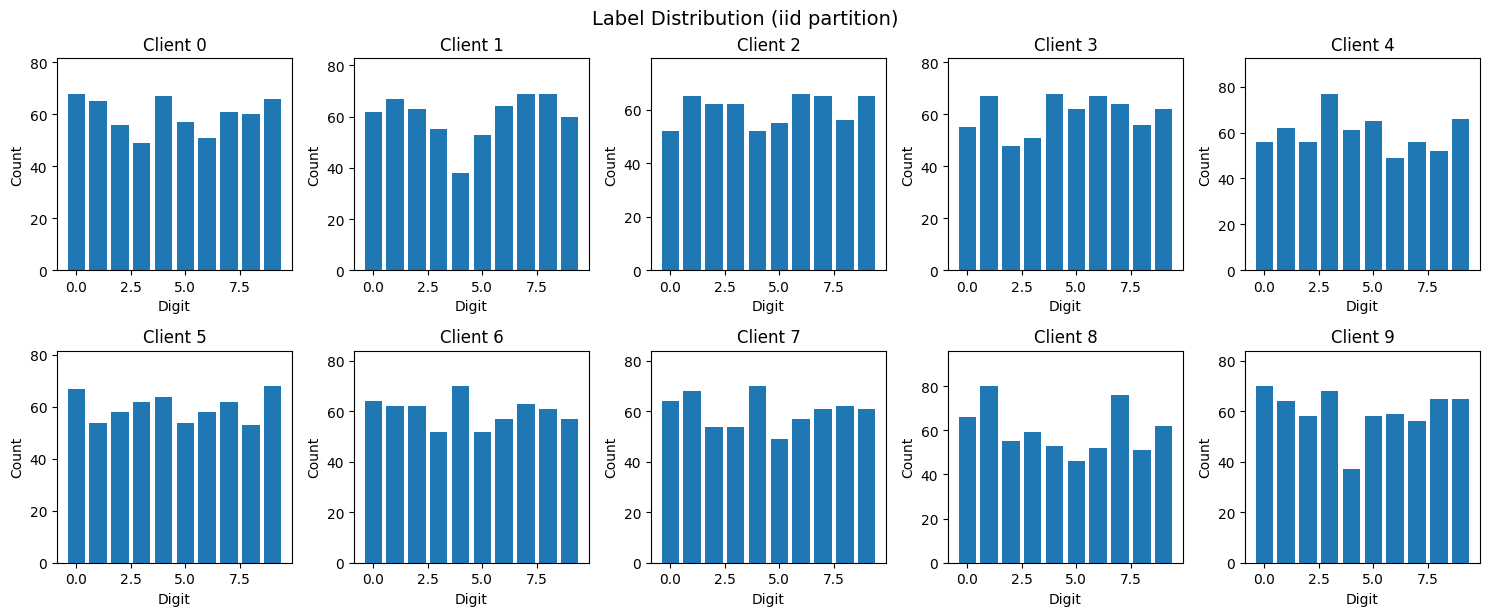

In [20]:
# Create partitions for current config
client_datasets = create_client_datasets(config, train_dataset)

# Visualize label distribution for first few clients
def plot_label_distribution(client_datasets, num_clients_to_plot=10):
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.flatten()
    
    for i in range(min(num_clients_to_plot, len(client_datasets))):
        targets = [train_dataset.targets[idx] for idx in client_datasets[i].indices]
        label_counts = np.bincount(targets, minlength=10)
        
        axes[i].bar(range(10), label_counts)
        axes[i].set_title(f'Client {i}')
        axes[i].set_xlabel('Digit')
        axes[i].set_ylabel('Count')
        axes[i].set_ylim([0, max(label_counts) * 1.2])
    
    plt.tight_layout()
    plt.suptitle(f"Label Distribution ({config['data_mode']} partition)", y=1.02, fontsize=14)
    plt.show()

plot_label_distribution(client_datasets)

## 3. Model Definition

Simple CNN architecture for MNIST - two convolutional layers followed by two fully connected layers.

In [21]:
class MNISTNet(nn.Module):
    def __init__(self):
        super(MNISTNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, padding=2)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 512)
        self.fc2 = nn.Linear(512, 10)
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


def create_model():
    """Factory function to create a fresh model instance."""
    return MNISTNet()


def get_model_params(model):
    """
    Extract model parameters as a state dict.
    Returns a deep copy to avoid aliasing issues.
    """
    return copy.deepcopy(model.state_dict())


def set_model_params(model, params):
    """
    Load parameters into a model.
    """
    model.load_state_dict(params)


def average_models(params_list, weights):
    """
    Weighted average of model parameters.
    
    Args:
        params_list: List of state dicts
        weights: List of weights (e.g., num samples per client)
    
    Returns:
        Averaged state dict
    """
    if len(params_list) == 0:
        return None
    
    # Normalize weights
    weights = np.array(weights, dtype=np.float32)
    weights /= weights.sum()
    
    avg_params = copy.deepcopy(params_list[0])
    
    for key in avg_params.keys():
        # Start with zeros
        avg_params[key] = torch.zeros_like(avg_params[key], dtype=torch.float32)
        
        # Weighted sum
        for i, params in enumerate(params_list):
            avg_params[key] += weights[i] * params[key].float()
    
    return avg_params


# Test model creation
test_model = create_model()
print(f"Model architecture:")
print(test_model)
print(f"\nTotal parameters: {sum(p.numel() for p in test_model.parameters())}")

Model architecture:
MNISTNet(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

Total parameters: 1663370


## 4. Synchronous FedAvg Baseline

Standard FedAvg algorithm:
1. Server broadcasts global model to selected clients
2. Clients train locally for E epochs
3. Server aggregates client updates via weighted averaging
4. Repeat for T rounds

In [22]:
class Client:
    def __init__(self, client_id, dataset, cfg):
        self.client_id = client_id
        self.dataset = dataset
        self.cfg = cfg
        self.dataloader = DataLoader(
            dataset, 
            batch_size=cfg['local_batch_size'], 
            shuffle=True
        )
    
    def local_update(self, global_params):
        """
        Perform local training for E epochs on client's data.
        
        Args:
            global_params: Current global model parameters
        
        Returns:
            Updated model parameters and training loss
        """
        model = create_model().to(self.cfg['device'])
        set_model_params(model, global_params)
        model.train()
        
        optimizer = torch.optim.SGD(
            model.parameters(), 
            lr=self.cfg['learning_rate']
        )
        criterion = nn.CrossEntropyLoss()
        
        epoch_losses = []
        
        for epoch in range(self.cfg['local_epochs']):
            batch_losses = []
            for data, target in self.dataloader:
                data, target = data.to(self.cfg['device']), target.to(self.cfg['device'])
                
                optimizer.zero_grad()
                output = model(data)
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()
                
                batch_losses.append(loss.item())
            
            epoch_losses.append(np.mean(batch_losses))
        
        updated_params = get_model_params(model)
        avg_loss = np.mean(epoch_losses)
        
        return updated_params, avg_loss
    
    def get_num_samples(self):
        return len(self.dataset)

In [23]:
def evaluate_model(params, test_loader, device):
    """
    Evaluate model on test set.
    
    Returns:
        accuracy, loss
    """
    model = create_model().to(device)
    set_model_params(model, params)
    model.eval()
    
    criterion = nn.CrossEntropyLoss()
    correct = 0
    total = 0
    total_loss = 0.0
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            
            total_loss += loss.item() * data.size(0)
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    
    accuracy = 100.0 * correct / total
    avg_loss = total_loss / total
    
    return accuracy, avg_loss

In [24]:
def server_round_sync(global_params, clients, cfg):
    """
    Execute one round of synchronous FedAvg.
    
    Args:
        global_params: Current global model parameters
        clients: List of all clients
        cfg: Configuration dict
    
    Returns:
        Updated global parameters
    """
    # Sample clients for this round
    num_selected = max(1, int(cfg['client_fraction'] * len(clients)))
    selected_clients = np.random.choice(clients, num_selected, replace=False)
    
    # Collect updates from selected clients
    client_params = []
    client_weights = []
    
    for client in selected_clients:
        params, loss = client.local_update(global_params)
        client_params.append(params)
        client_weights.append(client.get_num_samples())
    
    # Aggregate via weighted averaging
    new_global_params = average_models(client_params, client_weights)
    
    return new_global_params

In [25]:
def run_fedavg_sync(cfg, client_datasets, test_loader):
    """
    Main training loop for synchronous FedAvg.
    
    Returns:
        Dictionary with training history
    """
    # Initialize clients
    clients = [
        Client(i, client_datasets[i], cfg) 
        for i in range(cfg['num_clients'])
    ]
    
    # Initialize global model
    global_model = create_model()
    global_params = get_model_params(global_model)
    
    # Tracking metrics
    history = {
        'rounds': [],
        'test_acc': [],
        'test_loss': []
    }
    
    print("Starting synchronous FedAvg training...")
    print(f"Total clients: {cfg['num_clients']}, Selected per round: {int(cfg['client_fraction'] * cfg['num_clients'])}")
    
    for round_idx in range(cfg['num_rounds']):
        # Execute one round
        global_params = server_round_sync(global_params, clients, cfg)
        
        # Evaluate periodically
        if (round_idx + 1) % cfg['eval_every'] == 0 or round_idx == 0:
            acc, loss = evaluate_model(global_params, test_loader, cfg['device'])
            history['rounds'].append(round_idx + 1)
            history['test_acc'].append(acc)
            history['test_loss'].append(loss)
            
            print(f"Round {round_idx+1:3d}: Test Accuracy = {acc:.2f}%, Test Loss = {loss:.4f}")
    
    print("Training complete!")
    return history

## 5. Asynchronous / Delayed FedAvg

Simulate realistic system imperfections:
- **Variable delays**: Client updates arrive after random delays (network latency, computation time)
- **Client availability**: Not all clients are available in every round
- **Staleness**: Updates computed on old global parameters

Key difference from sync: Server maintains a queue of pending updates and applies them as they arrive.

In [26]:
def sample_delay(cfg):
    """
    Sample a delay (in rounds) for a client update.
    
    Returns:
        Integer delay >= 0
    """
    mode = cfg['delay_mode']
    
    if mode == 'none':
        return 0
    elif mode == 'uniform':
        return np.random.randint(0, cfg['max_delay'] + 1)
    elif mode == 'exponential':
        # Sample from exponential and clip to max_delay
        delay = int(np.random.exponential(cfg['max_delay'] / 2))
        return min(delay, cfg['max_delay'])
    else:
        raise ValueError(f"Unknown delay_mode: {mode}")


class AsyncUpdate:
    """Represents a pending asynchronous update."""
    def __init__(self, client_id, params, arrival_round, compute_round, num_samples):
        self.client_id = client_id
        self.params = params
        self.arrival_round = arrival_round
        self.compute_round = compute_round  # when it was computed
        self.num_samples = num_samples
    
    def get_staleness(self, current_round):
        """Staleness = delay between computation and application."""
        return current_round - self.compute_round

In [27]:
def run_fedavg_async(cfg, client_datasets, test_loader):
    """
    Asynchronous FedAvg with delays and client availability.
    
    At each round:
    1. Apply all updates that have arrived (aggregate them)
    2. Select available clients and schedule their updates with delays
    3. Evaluate and log metrics
    
    Returns:
        Dictionary with training history including staleness stats
    """
    # Initialize clients
    clients = [
        Client(i, client_datasets[i], cfg) 
        for i in range(cfg['num_clients'])
    ]
    
    # Initialize global model
    global_model = create_model()
    global_params = get_model_params(global_model)
    
    # Queue of pending updates, organized by arrival round
    pending_updates = defaultdict(list)  # arrival_round -> list of AsyncUpdate
    
    # Tracking metrics
    history = {
        'rounds': [],
        'test_acc': [],
        'test_loss': [],
        'staleness': [],  # staleness of each applied update
        'num_updates_per_round': []  # how many updates applied per round
    }
    
    print("Starting asynchronous FedAvg training...")
    print(f"Delay mode: {cfg['delay_mode']}, Max delay: {cfg['max_delay']}")
    print(f"Client availability: {cfg['p_available']}")
    
    for round_idx in range(cfg['num_rounds']):
        current_round = round_idx + 1
        
        # Step 1: Apply arriving updates
        if current_round in pending_updates:
            arriving = pending_updates[current_round]
            
            # Filter out stale updates if max_staleness is set
            if cfg['max_staleness'] is not None:
                arriving = [
                    upd for upd in arriving 
                    if upd.get_staleness(current_round) <= cfg['max_staleness']
                ]
            
            if len(arriving) > 0:
                # Aggregate all arriving updates
                params_list = [upd.params for upd in arriving]
                weights_list = [upd.num_samples for upd in arriving]
                
                # Track staleness
                for upd in arriving:
                    history['staleness'].append(upd.get_staleness(current_round))
                
                # Update global parameters
                aggregated = average_models(params_list, weights_list)
                global_params = aggregated
            
            history['num_updates_per_round'].append(len(arriving))
            del pending_updates[current_round]
        else:
            history['num_updates_per_round'].append(0)
        
        # Step 2: Select and schedule new client updates
        # First determine which clients are available
        available_mask = np.random.rand(len(clients)) < cfg['p_available']
        available_clients = [c for i, c in enumerate(clients) if available_mask[i]]
        
        if len(available_clients) > 0:
            # Sample from available clients
            num_selected = max(1, int(cfg['client_fraction'] * len(clients)))
            num_selected = min(num_selected, len(available_clients))
            selected = np.random.choice(available_clients, num_selected, replace=False)
            
            for client in selected:
                # Client computes update based on current global params
                params, loss = client.local_update(global_params)
                
                # Sample delay
                delay = sample_delay(cfg)
                arrival_round = current_round + delay
                
                # Schedule update
                update = AsyncUpdate(
                    client_id=client.client_id,
                    params=params,
                    arrival_round=arrival_round,
                    compute_round=current_round,
                    num_samples=client.get_num_samples()
                )
                pending_updates[arrival_round].append(update)
        
        # Step 3: Evaluate periodically
        if current_round % cfg['eval_every'] == 0 or current_round == 1:
            acc, loss = evaluate_model(global_params, test_loader, cfg['device'])
            history['rounds'].append(current_round)
            history['test_acc'].append(acc)
            history['test_loss'].append(loss)
            
            avg_staleness = np.mean(history['staleness']) if len(history['staleness']) > 0 else 0
            print(f"Round {current_round:3d}: Test Acc = {acc:.2f}%, "
                  f"Avg Staleness = {avg_staleness:.2f}")
    
    print("Training complete!")
    
    # Summary statistics
    if len(history['staleness']) > 0:
        print(f"\nStaleness statistics:")
        print(f"  Mean: {np.mean(history['staleness']):.2f}")
        print(f"  Max: {np.max(history['staleness'])}")
        print(f"  Median: {np.median(history['staleness']):.2f}")
    
    return history

## 6. Experiments and Visualization

We'll run a series of experiments to understand how non-IID data and delays affect convergence.

In [28]:
# Experiment 1: Synchronous baseline with IID data
print("=" * 60)
print("Experiment 1: Sync FedAvg with IID data")
print("=" * 60)

config_sync_iid = config.copy()
config_sync_iid['data_mode'] = 'iid'
config_sync_iid['delay_mode'] = 'none'
set_seed(config['seed'])

client_datasets_iid = create_client_datasets(config_sync_iid, train_dataset)
history_sync_iid = run_fedavg_sync(config_sync_iid, client_datasets_iid, test_loader)

Experiment 1: Sync FedAvg with IID data
Partitioning mode: iid
Client dataset sizes - min: 600, max: 600, mean: 600.0
Starting synchronous FedAvg training...
Total clients: 100, Selected per round: 10
Round   1: Test Accuracy = 78.48%, Test Loss = 1.2382
Round   5: Test Accuracy = 93.56%, Test Loss = 0.2247
Round  10: Test Accuracy = 95.65%, Test Loss = 0.1362
Round  15: Test Accuracy = 96.92%, Test Loss = 0.0975
Round  20: Test Accuracy = 97.35%, Test Loss = 0.0799
Round  25: Test Accuracy = 97.82%, Test Loss = 0.0673
Round  30: Test Accuracy = 98.01%, Test Loss = 0.0596
Round  35: Test Accuracy = 98.25%, Test Loss = 0.0529
Round  40: Test Accuracy = 98.27%, Test Loss = 0.0508
Round  45: Test Accuracy = 98.40%, Test Loss = 0.0459
Round  50: Test Accuracy = 98.44%, Test Loss = 0.0427
Round  55: Test Accuracy = 98.58%, Test Loss = 0.0402
Round  60: Test Accuracy = 98.63%, Test Loss = 0.0394
Round  65: Test Accuracy = 98.61%, Test Loss = 0.0381
Round  70: Test Accuracy = 98.72%, Test Los

In [29]:
# Experiment 2: Synchronous with non-IID data (Dirichlet)
print("\n" + "=" * 60)
print("Experiment 2: Sync FedAvg with non-IID data (Dirichlet α=0.5)")
print("=" * 60)

config_sync_noniid = config.copy()
config_sync_noniid['data_mode'] = 'dirichlet'
config_sync_noniid['dirichlet_alpha'] = 0.5
config_sync_noniid['delay_mode'] = 'none'
set_seed(config['seed'])

client_datasets_noniid = create_client_datasets(config_sync_noniid, train_dataset)
history_sync_noniid = run_fedavg_sync(config_sync_noniid, client_datasets_noniid, test_loader)


Experiment 2: Sync FedAvg with non-IID data (Dirichlet α=0.5)
Partitioning mode: dirichlet
Client dataset sizes - min: 81, max: 1658, mean: 600.0
Starting synchronous FedAvg training...
Total clients: 100, Selected per round: 10


/var/folders/53/p0cspydd0nn22ts55flx9ynm0000gn/T/ipykernel_22899/600767221.py:32: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  targets = np.array(dataset.targets)


Round   1: Test Accuracy = 57.07%, Test Loss = 1.4342
Round   5: Test Accuracy = 91.28%, Test Loss = 0.2907
Round  10: Test Accuracy = 94.78%, Test Loss = 0.1650
Round  15: Test Accuracy = 95.67%, Test Loss = 0.1390
Round  20: Test Accuracy = 96.54%, Test Loss = 0.1032
Round  25: Test Accuracy = 97.23%, Test Loss = 0.0804
Round  30: Test Accuracy = 97.33%, Test Loss = 0.0809
Round  35: Test Accuracy = 97.87%, Test Loss = 0.0672
Round  40: Test Accuracy = 98.27%, Test Loss = 0.0562
Round  45: Test Accuracy = 98.29%, Test Loss = 0.0547
Round  50: Test Accuracy = 98.17%, Test Loss = 0.0516
Round  55: Test Accuracy = 98.54%, Test Loss = 0.0457
Round  60: Test Accuracy = 98.45%, Test Loss = 0.0447
Round  65: Test Accuracy = 98.32%, Test Loss = 0.0455
Round  70: Test Accuracy = 95.70%, Test Loss = 0.1281
Round  75: Test Accuracy = 98.48%, Test Loss = 0.0430
Round  80: Test Accuracy = 98.62%, Test Loss = 0.0407
Round  85: Test Accuracy = 98.74%, Test Loss = 0.0359
Round  90: Test Accuracy = 9

In [30]:
# Experiment 3: Async with IID data and moderate delays
print("\n" + "=" * 60)
print("Experiment 3: Async FedAvg with IID data and delays")
print("=" * 60)

config_async_iid = config.copy()
config_async_iid['data_mode'] = 'iid'
config_async_iid['delay_mode'] = 'uniform'
config_async_iid['max_delay'] = 5
config_async_iid['p_available'] = 0.8  # 80% availability
set_seed(config['seed'])

client_datasets_iid_2 = create_client_datasets(config_async_iid, train_dataset)
history_async_iid = run_fedavg_async(config_async_iid, client_datasets_iid_2, test_loader)


Experiment 3: Async FedAvg with IID data and delays
Partitioning mode: iid
Client dataset sizes - min: 600, max: 600, mean: 600.0
Starting asynchronous FedAvg training...
Delay mode: uniform, Max delay: 5
Client availability: 0.8
Round   1: Test Acc = 13.03%, Avg Staleness = 0.00
Round   5: Test Acc = 87.96%, Avg Staleness = 1.77
Round  10: Test Acc = 92.29%, Avg Staleness = 2.80
Round  15: Test Acc = 93.71%, Avg Staleness = 2.97
Round  20: Test Acc = 94.64%, Avg Staleness = 2.96
Round  25: Test Acc = 95.21%, Avg Staleness = 3.04
Round  30: Test Acc = 95.74%, Avg Staleness = 3.05
Round  35: Test Acc = 96.25%, Avg Staleness = 3.06
Round  40: Test Acc = 96.63%, Avg Staleness = 3.05
Round  45: Test Acc = 96.98%, Avg Staleness = 3.05
Round  50: Test Acc = 96.97%, Avg Staleness = 3.06
Round  55: Test Acc = 97.34%, Avg Staleness = 3.04
Round  60: Test Acc = 97.59%, Avg Staleness = 3.02
Round  65: Test Acc = 97.76%, Avg Staleness = 3.03
Round  70: Test Acc = 97.72%, Avg Staleness = 3.03
Roun

In [31]:
# Experiment 4: Async with non-IID data and moderate delays
print("\n" + "=" * 60)
print("Experiment 4: Async FedAvg with non-IID data and delays")
print("=" * 60)

config_async_noniid = config.copy()
config_async_noniid['data_mode'] = 'dirichlet'
config_async_noniid['dirichlet_alpha'] = 0.5
config_async_noniid['delay_mode'] = 'uniform'
config_async_noniid['max_delay'] = 5
config_async_noniid['p_available'] = 0.8
set_seed(config['seed'])

client_datasets_noniid_2 = create_client_datasets(config_async_noniid, train_dataset)
history_async_noniid = run_fedavg_async(config_async_noniid, client_datasets_noniid_2, test_loader)


Experiment 4: Async FedAvg with non-IID data and delays
Partitioning mode: dirichlet
Client dataset sizes - min: 81, max: 1658, mean: 600.0
Starting asynchronous FedAvg training...
Delay mode: uniform, Max delay: 5
Client availability: 0.8


/var/folders/53/p0cspydd0nn22ts55flx9ynm0000gn/T/ipykernel_22899/600767221.py:32: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  targets = np.array(dataset.targets)


Round   1: Test Acc = 13.03%, Avg Staleness = 0.00
Round   5: Test Acc = 70.46%, Avg Staleness = 2.18
Round  10: Test Acc = 89.85%, Avg Staleness = 2.63
Round  15: Test Acc = 92.63%, Avg Staleness = 2.58
Round  20: Test Acc = 92.29%, Avg Staleness = 2.76
Round  25: Test Acc = 94.70%, Avg Staleness = 2.83
Round  30: Test Acc = 93.96%, Avg Staleness = 2.90
Round  35: Test Acc = 95.41%, Avg Staleness = 2.89
Round  40: Test Acc = 94.57%, Avg Staleness = 2.91
Round  45: Test Acc = 96.62%, Avg Staleness = 2.92
Round  50: Test Acc = 96.56%, Avg Staleness = 2.86
Round  55: Test Acc = 96.88%, Avg Staleness = 2.90
Round  60: Test Acc = 97.06%, Avg Staleness = 2.91
Round  65: Test Acc = 97.36%, Avg Staleness = 2.91
Round  70: Test Acc = 97.30%, Avg Staleness = 2.92
Round  75: Test Acc = 97.43%, Avg Staleness = 2.90
Round  80: Test Acc = 97.34%, Avg Staleness = 2.92
Round  85: Test Acc = 97.80%, Avg Staleness = 2.95
Round  90: Test Acc = 97.57%, Avg Staleness = 2.95
Round  95: Test Acc = 97.90%, A

In [32]:
# Experiment 5: Async with non-IID and heavy delays (stress test)
print("\n" + "=" * 60)
print("Experiment 5: Async FedAvg with non-IID and heavy delays")
print("=" * 60)

config_async_heavy = config.copy()
config_async_heavy['data_mode'] = 'dirichlet'
config_async_heavy['dirichlet_alpha'] = 0.3  # More heterogeneous
config_async_heavy['delay_mode'] = 'uniform'
config_async_heavy['max_delay'] = 15
config_async_heavy['p_available'] = 0.6  # Lower availability
set_seed(config['seed'])

client_datasets_heavy = create_client_datasets(config_async_heavy, train_dataset)
history_async_heavy = run_fedavg_async(config_async_heavy, client_datasets_heavy, test_loader)


Experiment 5: Async FedAvg with non-IID and heavy delays
Partitioning mode: dirichlet
Client dataset sizes - min: 22, max: 1705, mean: 600.0
Starting asynchronous FedAvg training...
Delay mode: uniform, Max delay: 15
Client availability: 0.6


/var/folders/53/p0cspydd0nn22ts55flx9ynm0000gn/T/ipykernel_22899/600767221.py:32: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  targets = np.array(dataset.targets)


Round   1: Test Acc = 13.03%, Avg Staleness = 0.00
Round   5: Test Acc = 56.14%, Avg Staleness = 2.43
Round  10: Test Acc = 68.70%, Avg Staleness = 3.92
Round  15: Test Acc = 83.15%, Avg Staleness = 5.75
Round  20: Test Acc = 83.42%, Avg Staleness = 6.74
Round  25: Test Acc = 90.11%, Avg Staleness = 7.31
Round  30: Test Acc = 89.77%, Avg Staleness = 7.66
Round  35: Test Acc = 92.83%, Avg Staleness = 7.63
Round  40: Test Acc = 92.02%, Avg Staleness = 7.56
Round  45: Test Acc = 92.73%, Avg Staleness = 7.68
Round  50: Test Acc = 88.58%, Avg Staleness = 7.67
Round  55: Test Acc = 93.70%, Avg Staleness = 7.79
Round  60: Test Acc = 94.50%, Avg Staleness = 7.80
Round  65: Test Acc = 92.69%, Avg Staleness = 7.77
Round  70: Test Acc = 94.01%, Avg Staleness = 7.75
Round  75: Test Acc = 94.51%, Avg Staleness = 7.79
Round  80: Test Acc = 94.01%, Avg Staleness = 7.76
Round  85: Test Acc = 94.80%, Avg Staleness = 7.76
Round  90: Test Acc = 94.91%, Avg Staleness = 7.78
Round  95: Test Acc = 95.05%, A

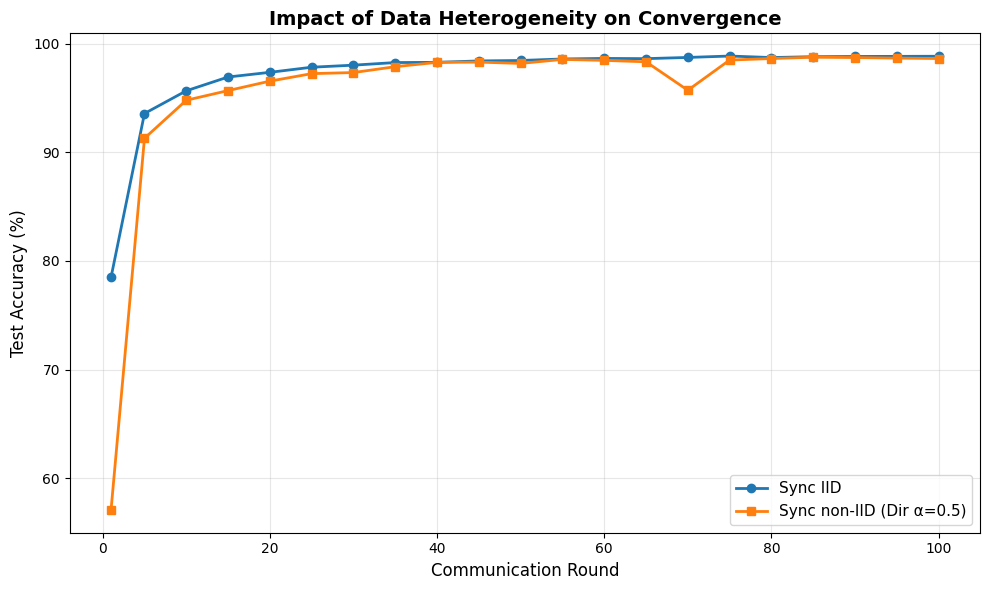

Final accuracy - Sync IID: 98.83%
Final accuracy - Sync non-IID: 98.62%


In [33]:
# Plot 1: Impact of data heterogeneity (Sync only)
plt.figure(figsize=(10, 6))
plt.plot(history_sync_iid['rounds'], history_sync_iid['test_acc'], 
         marker='o', linewidth=2, label='Sync IID')
plt.plot(history_sync_noniid['rounds'], history_sync_noniid['test_acc'], 
         marker='s', linewidth=2, label='Sync non-IID (Dir α=0.5)')
plt.xlabel('Communication Round', fontsize=12)
plt.ylabel('Test Accuracy (%)', fontsize=12)
plt.title('Impact of Data Heterogeneity on Convergence', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Final accuracy - Sync IID: {history_sync_iid['test_acc'][-1]:.2f}%")
print(f"Final accuracy - Sync non-IID: {history_sync_noniid['test_acc'][-1]:.2f}%")

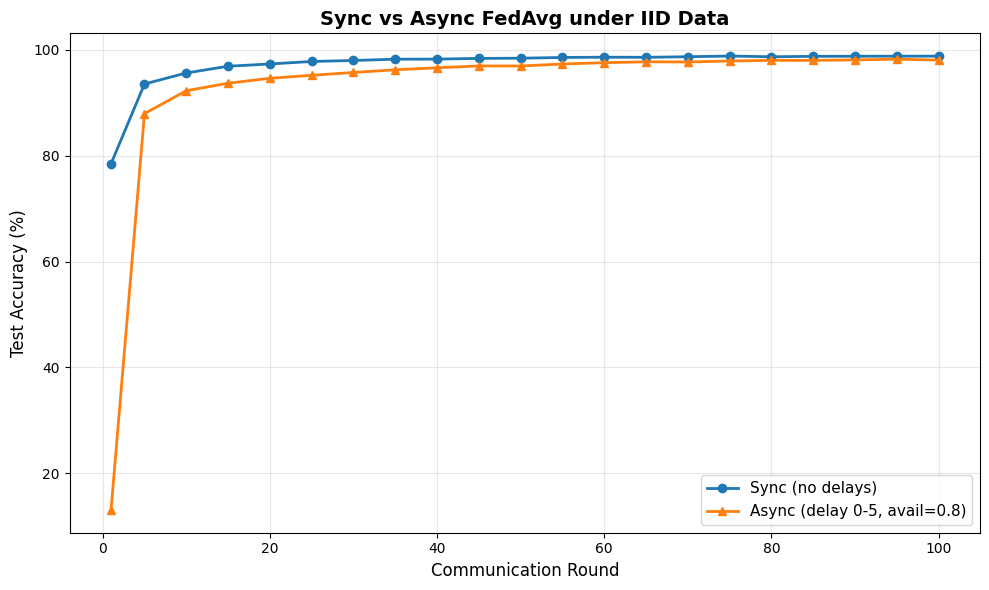

Final accuracy - Sync: 98.83%
Final accuracy - Async: 98.08%


In [34]:
# Plot 2: Sync vs Async under IID data
plt.figure(figsize=(10, 6))
plt.plot(history_sync_iid['rounds'], history_sync_iid['test_acc'], 
         marker='o', linewidth=2, label='Sync (no delays)')
plt.plot(history_async_iid['rounds'], history_async_iid['test_acc'], 
         marker='^', linewidth=2, label='Async (delay 0-5, avail=0.8)')
plt.xlabel('Communication Round', fontsize=12)
plt.ylabel('Test Accuracy (%)', fontsize=12)
plt.title('Sync vs Async FedAvg under IID Data', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Final accuracy - Sync: {history_sync_iid['test_acc'][-1]:.2f}%")
print(f"Final accuracy - Async: {history_async_iid['test_acc'][-1]:.2f}%")

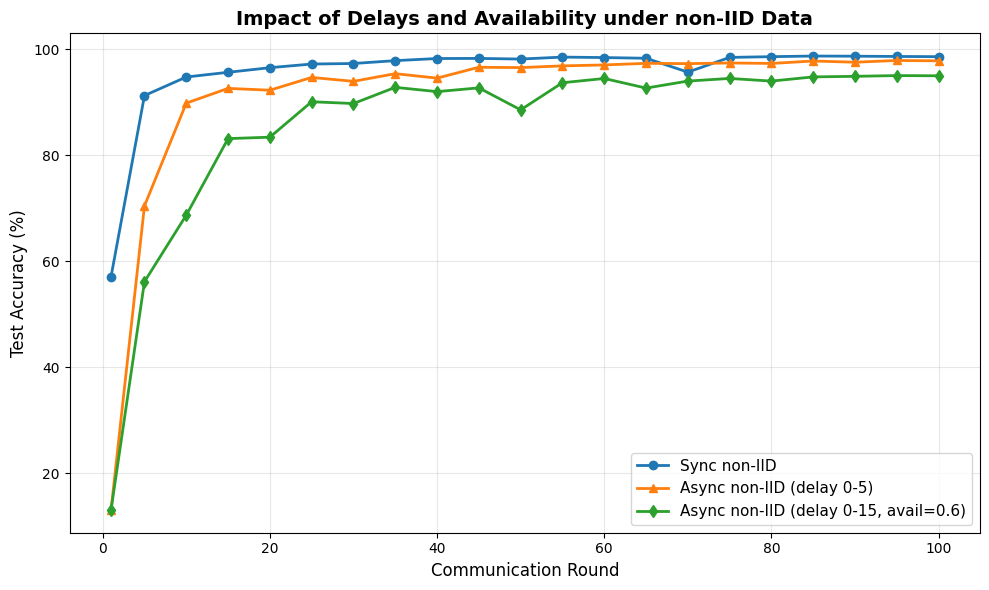

Final accuracy - Sync: 98.62%
Final accuracy - Async moderate: 97.83%
Final accuracy - Async heavy: 95.01%


In [35]:
# Plot 3: Sync vs Async under non-IID data
plt.figure(figsize=(10, 6))
plt.plot(history_sync_noniid['rounds'], history_sync_noniid['test_acc'], 
         marker='o', linewidth=2, label='Sync non-IID')
plt.plot(history_async_noniid['rounds'], history_async_noniid['test_acc'], 
         marker='^', linewidth=2, label='Async non-IID (delay 0-5)')
plt.plot(history_async_heavy['rounds'], history_async_heavy['test_acc'], 
         marker='d', linewidth=2, label='Async non-IID (delay 0-15, avail=0.6)')
plt.xlabel('Communication Round', fontsize=12)
plt.ylabel('Test Accuracy (%)', fontsize=12)
plt.title('Impact of Delays and Availability under non-IID Data', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Final accuracy - Sync: {history_sync_noniid['test_acc'][-1]:.2f}%")
print(f"Final accuracy - Async moderate: {history_async_noniid['test_acc'][-1]:.2f}%")
print(f"Final accuracy - Async heavy: {history_async_heavy['test_acc'][-1]:.2f}%")

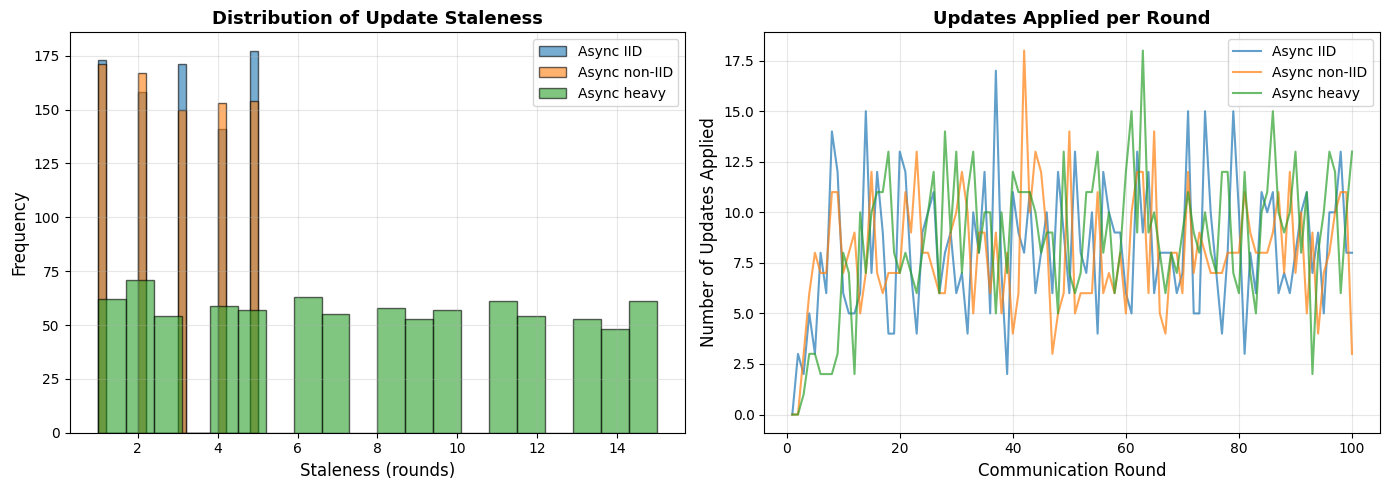


Async IID staleness:
  Mean: 2.99
  Std: 1.44
  Max: 5

Async non-IID staleness:
  Mean: 2.94
  Std: 1.43
  Max: 5

Async heavy staleness:
  Mean: 7.80
  Std: 4.35
  Max: 15


In [36]:
# Plot 4: Staleness analysis for async runs
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram of staleness
axes[0].hist(history_async_iid['staleness'], bins=20, alpha=0.6, label='Async IID', edgecolor='black')
axes[0].hist(history_async_noniid['staleness'], bins=20, alpha=0.6, label='Async non-IID', edgecolor='black')
axes[0].hist(history_async_heavy['staleness'], bins=20, alpha=0.6, label='Async heavy', edgecolor='black')
axes[0].set_xlabel('Staleness (rounds)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Distribution of Update Staleness', fontsize=13, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Updates per round
rounds_plot = range(1, len(history_async_iid['num_updates_per_round']) + 1)
axes[1].plot(rounds_plot, history_async_iid['num_updates_per_round'], 
             alpha=0.7, linewidth=1.5, label='Async IID')
axes[1].plot(rounds_plot, history_async_noniid['num_updates_per_round'], 
             alpha=0.7, linewidth=1.5, label='Async non-IID')
axes[1].plot(rounds_plot, history_async_heavy['num_updates_per_round'], 
             alpha=0.7, linewidth=1.5, label='Async heavy')
axes[1].set_xlabel('Communication Round', fontsize=12)
axes[1].set_ylabel('Number of Updates Applied', fontsize=12)
axes[1].set_title('Updates Applied per Round', fontsize=13, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print staleness statistics
for name, hist in [('Async IID', history_async_iid), 
                   ('Async non-IID', history_async_noniid),
                   ('Async heavy', history_async_heavy)]:
    if len(hist['staleness']) > 0:
        print(f"\n{name} staleness:")
        print(f"  Mean: {np.mean(hist['staleness']):.2f}")
        print(f"  Std: {np.std(hist['staleness']):.2f}")
        print(f"  Max: {np.max(hist['staleness'])}")

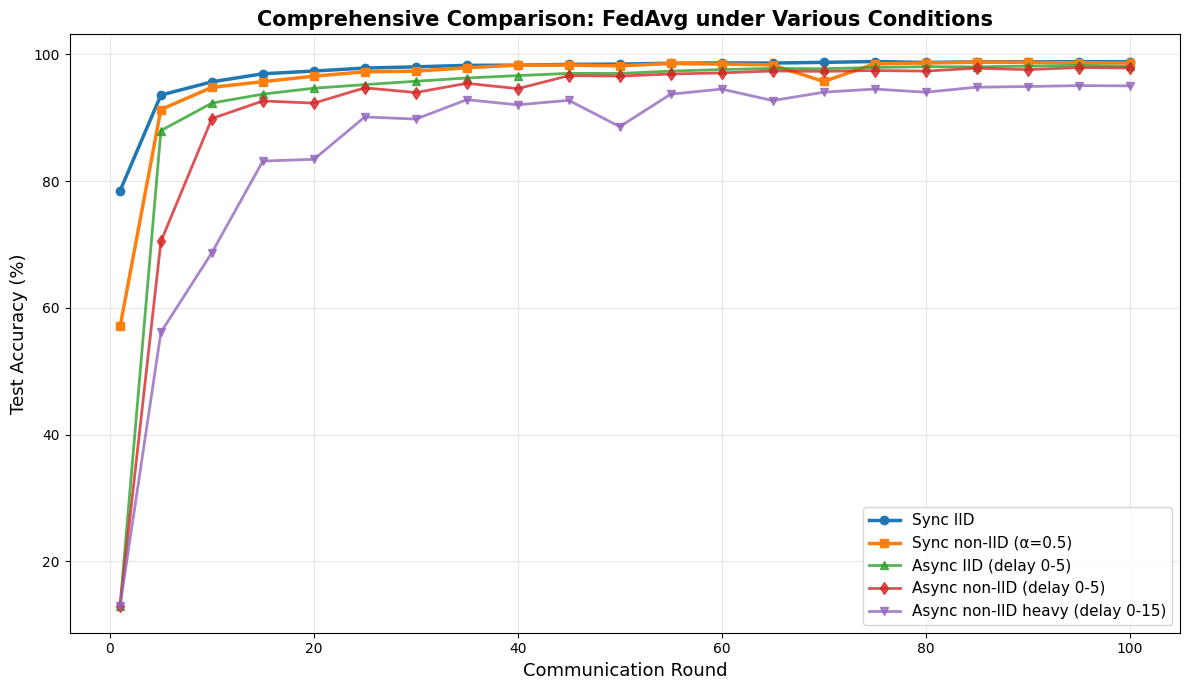

In [37]:
# Comprehensive comparison plot
plt.figure(figsize=(12, 7))

plt.plot(history_sync_iid['rounds'], history_sync_iid['test_acc'], 
         marker='o', linewidth=2.5, markersize=6, label='Sync IID')
plt.plot(history_sync_noniid['rounds'], history_sync_noniid['test_acc'], 
         marker='s', linewidth=2.5, markersize=6, label='Sync non-IID (α=0.5)')
plt.plot(history_async_iid['rounds'], history_async_iid['test_acc'], 
         marker='^', linewidth=2, markersize=6, alpha=0.8, label='Async IID (delay 0-5)')
plt.plot(history_async_noniid['rounds'], history_async_noniid['test_acc'], 
         marker='d', linewidth=2, markersize=6, alpha=0.8, label='Async non-IID (delay 0-5)')
plt.plot(history_async_heavy['rounds'], history_async_heavy['test_acc'], 
         marker='v', linewidth=2, markersize=6, alpha=0.8, label='Async non-IID heavy (delay 0-15)')

plt.xlabel('Communication Round', fontsize=13)
plt.ylabel('Test Accuracy (%)', fontsize=13)
plt.title('Comprehensive Comparison: FedAvg under Various Conditions', fontsize=15, fontweight='bold')
plt.legend(fontsize=11, loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()